#Build to tflite

In [ ]:
import tensorflow as tf
import numpy as np
import json
from scipy.spatial.distance import cdist

# Fungsi collaborative filtering menggunakan pendekatan Item-based CF
def collaborative_filtering(item_preferences, target_item):
    distances = []
    for item in item_preferences.keys():
        if item != target_item and item in hospital_data:
            distances.append(cdist([hospital_data[item]], [hospital_data[target_item]]))
    if not distances:
        return np.zeros(len(item_preferences))  # Jika tidak ada rumah sakit yang sesuai, kembalikan array nol dengan panjang yang sama dengan item_preferences
    distances = np.array(distances)
    similarities = 1 / (1 + distances)
    return np.mean(similarities, axis=0)

# Load hospital data from JSON file
with open('hospitals.json') as f:
    data = json.load(f)
    hospital_data = {item['fields']['name']['stringValue']: [
        item['fields']['coordinate']['mapValue']['fields']['latitude']['doubleValue'],
        item['fields']['coordinate']['mapValue']['fields']['longitude']['doubleValue']
    ] for item in data['documents']}

# Ubah hospital_data menjadi tensor TensorFlow
hospital_coordinates = tf.constant(list(hospital_data.values()), dtype=tf.float32)
hospital_names = list(hospital_data.keys())

# Buat input signature
input_signature = [
    tf.TensorSpec(shape=(None, 2), dtype=tf.float32, name='input_coordinates'),
    tf.TensorSpec(shape=(), dtype=tf.string, name='target_item')
]

# Buat model TensorFlow
@tf.function(input_signature=input_signature)
def collaborative_filtering_tf(coordinates, target_item):
    # Ubah dictionary hospital_data menjadi tensor TensorFlow
    target_item_idx = tf.where(tf.equal(hospital_names, target_item))[0, 0]
    target_item_coord = tf.gather(hospital_coordinates, target_item_idx)
    target_item_coord = tf.expand_dims(target_item_coord, axis=0)
    target_item_coord = tf.cast(target_item_coord, dtype=tf.float32)

    distances = tf.norm(hospital_coordinates - target_item_coord, axis=1)
    similarities = 1 / (1 + distances)

    return tf.reduce_mean(similarities, axis=0)

# Simpan model TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_concrete_functions([collaborative_filtering_tf.get_concrete_function()], trackable_obj=collaborative_filtering_tf)
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS]
tflite_model = converter.convert()

# Simpan model TensorFlow Lite ke dalam file
with open('modelfilltering.tflite', 'wb') as f:
    f.write(tflite_model)


#Ditambahkan Training dan create graf

Epoch 1/100
1/1 [==============================] - 1s 927ms/step - loss: 6217.0420 - accuracy: 0.0000e+00 - val_loss: 5880.8203 - val_accuracy: 0.0000e+00
Epoch 2/100
1/1 [==============================] - 0s 38ms/step - loss: 5878.5225 - accuracy: 0.0000e+00 - val_loss: 5551.2646 - val_accuracy: 1.0000
Epoch 3/100
1/1 [==============================] - 0s 41ms/step - loss: 5549.0957 - accuracy: 1.0000 - val_loss: 5239.9766 - val_accuracy: 1.0000
Epoch 4/100
1/1 [==============================] - 0s 42ms/step - loss: 5237.9316 - accuracy: 1.0000 - val_loss: 4949.2061 - val_accuracy: 1.0000
Epoch 5/100
1/1 [==============================] - 0s 39ms/step - loss: 4947.2744 - accuracy: 1.0000 - val_loss: 4666.2109 - val_accuracy: 1.0000
Epoch 6/100
1/1 [==============================] - 0s 41ms/step - loss: 4664.3906 - accuracy: 1.0000 - val_loss: 4391.0615 - val_accuracy: 1.0000
Epoch 7/100
1/1 [==============================] - 0s 43ms/step - loss: 4389.3477 - accuracy: 1.0000 - val_loss

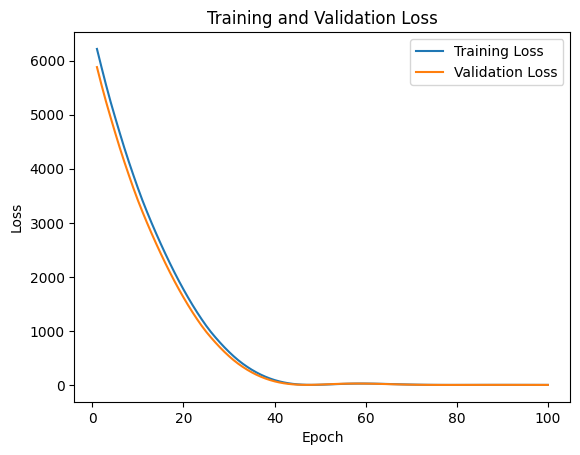

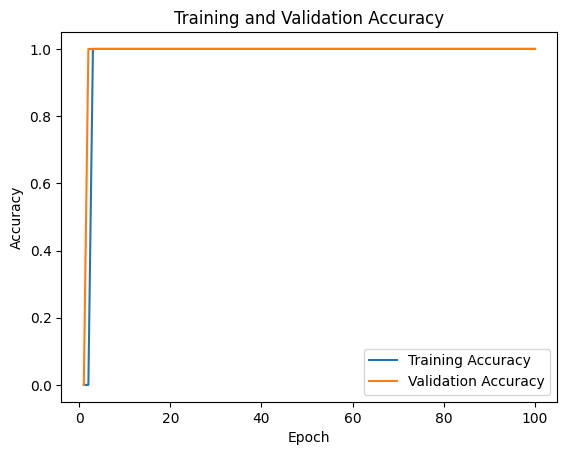

In [10]:
import tensorflow as tf
import numpy as np
import json
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt

# Fungsi collaborative filtering menggunakan pendekatan Item-based CF
def collaborative_filtering(item_preferences, target_item):
    distances = []
    for item in item_preferences.keys():
        if item != target_item and item in hospital_data:
            distances.append(cdist([hospital_data[item]], [hospital_data[target_item]]))
    if not distances:
        return np.zeros(len(item_preferences))  # Jika tidak ada rumah sakit yang sesuai, kembalikan array nol dengan panjang yang sama dengan item_preferences
    distances = np.array(distances)
    similarities = 1 / (1 + distances)
    return np.mean(similarities, axis=0)

# Load hospital data from JSON file
with open('hospitals.json') as f:
    data = json.load(f)
    hospital_data = {item['fields']['name']['stringValue']: [
        item['fields']['coordinate']['mapValue']['fields']['latitude']['doubleValue'],
        item['fields']['coordinate']['mapValue']['fields']['longitude']['doubleValue']
    ] for item in data['documents']}

# Ubah hospital_data menjadi tensor TensorFlow
hospital_coordinates = tf.constant(list(hospital_data.values()), dtype=tf.float32)
hospital_names = list(hospital_data.keys())

# Buat input signature
input_signature = [
    tf.TensorSpec(shape=(None, 2), dtype=tf.float32, name='input_coordinates'),
    tf.TensorSpec(shape=(), dtype=tf.string, name='target_item')
]

# Buat model TensorFlow
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(2,)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(2)
])

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

# Simpan model TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Simpan model TensorFlow Lite ke dalam file
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)

# Melakukan pelatihan model dengan 100 epoch
history = model.fit(x=hospital_coordinates, y=hospital_coordinates, epochs=100, validation_split=0.2)

# Ambil nilai loss dari setiap epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Ambil nilai accuracy dari setiap epoch
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Plot grafik perubahan loss
plt.plot(range(1, len(loss) + 1), loss, label='Training Loss')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Plot grafik perubahan accuracy
plt.plot(range(1, len(accuracy) + 1), accuracy, label='Training Accuracy')
plt.plot(range(1, len(val_accuracy) + 1), val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()


MSE

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            (None, 64)                192       
                                                                 
 dense_21 (Dense)            (None, 64)                4160      
                                                                 
 dense_22 (Dense)            (None, 2)                 130       
                                                                 
Total params: 4,482
Trainable params: 4,482
Non-trainable params: 0
_________________________________________________________________


Epoch 1/100
1/1 [==============================] - 3s 3s/step - loss: 6628.9893 - mse: 6628.9893 - val_loss: 6386.6621 - val_mse: 6386.6621
Epoch 2/100
1/1 [==============================] - 0s 44ms/step - loss: 6384.1514 - mse: 6384.1514 - val_loss: 6148.3965 - val_mse: 6148.3965
Epoch 3/100
1/1 [==============================] - 0s 61ms/step - loss: 6145.9771 - mse: 6145.9771 - val_loss: 5915.3096 - val_mse: 5915.3096
Epoch 4/100
1/1 [==============================] - 0s 38ms/step - loss: 5912.9810 - mse: 5912.9810 - val_loss: 5687.9019 - val_mse: 5687.9019
Epoch 5/100
1/1 [==============================] - 0s 44ms/step - loss: 5685.6572 - mse: 5685.6572 - val_loss: 5473.7979 - val_mse: 5473.7979
Epoch 6/100
1/1 [==============================] - 0s 38ms/step - loss: 5471.6377 - mse: 5471.6377 - val_loss: 5267.7920 - val_mse: 5267.7920
Epoch 7/100
1/1 [==============================] - 0s 35ms/step - loss: 5265.7080 - mse: 5265.7080 - val_loss: 5070.8613 - val_mse: 5070.8613
Epoch 8/

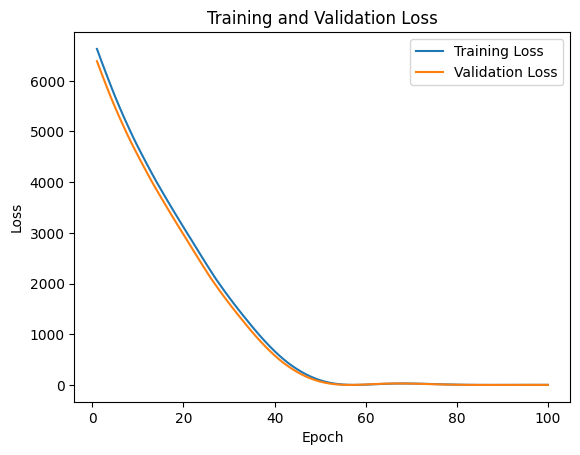

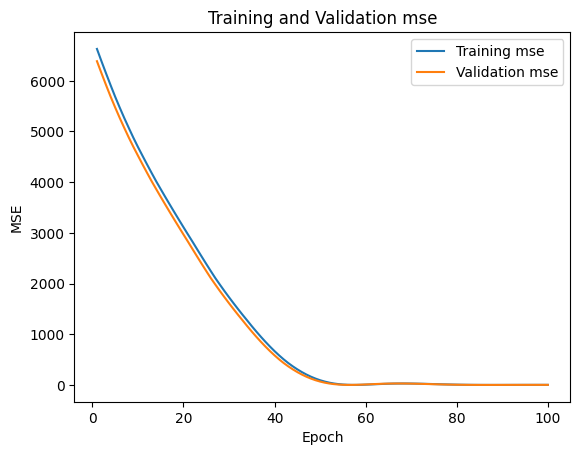

In [14]:
import tensorflow as tf
import numpy as np
import json
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt

# Fungsi collaborative filtering menggunakan pendekatan Item-based CF
def collaborative_filtering(item_preferences, target_item):
    distances = []
    for item in item_preferences.keys():
        if item != target_item and item in hospital_data:
            distances.append(cdist([hospital_data[item]], [hospital_data[target_item]]))
    if not distances:
        return np.zeros(len(item_preferences))  # Jika tidak ada rumah sakit yang sesuai, kembalikan array nol dengan panjang yang sama dengan item_preferences
    distances = np.array(distances)
    similarities = 1 / (1 + distances)
    return np.mean(similarities, axis=0)

# Load hospital data from JSON file
with open('hospitals.json') as f:
    data = json.load(f)
    hospital_data = {item['fields']['name']['stringValue']: [
        item['fields']['coordinate']['mapValue']['fields']['latitude']['doubleValue'],
        item['fields']['coordinate']['mapValue']['fields']['longitude']['doubleValue']
    ] for item in data['documents']}

# Ubah hospital_data menjadi tensor TensorFlow
hospital_coordinates = tf.constant(list(hospital_data.values()), dtype=tf.float32)
hospital_names = list(hospital_data.keys())

# Buat input signature
input_signature = [
    tf.TensorSpec(shape=(None, 2), dtype=tf.float32, name='input_coordinates'),
    tf.TensorSpec(shape=(), dtype=tf.string, name='target_item')
]

# Buat model TensorFlow
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(2,)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(2)
])

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])

model.summary()

# Simpan model TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Simpan model TensorFlow Lite ke dalam file
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)

# Melakukan pelatihan model dengan 100 epoch
history = model.fit(x=hospital_coordinates, y=hospital_coordinates, epochs=100, validation_split=0.2)

# Ambil nilai loss dari setiap epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Ambil nilai accuracy dari setiap epoch
accuracy = history.history['mse']
val_accuracy = history.history['val_mse']

# Plot grafik perubahan loss
plt.plot(range(1, len(loss) + 1), loss, label='Training Loss')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Plot grafik perubahan accuracy
plt.plot(range(1, len(accuracy) + 1), accuracy, label='Training mse')
plt.plot(range(1, len(val_accuracy) + 1), val_accuracy, label='Validation mse')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title('Training and Validation mse')
plt.legend()
plt.show()


Sampai sini